# Julia Workshop, Day 5: Documentation, Organizing Programs, Workflow

Goals for today:

- Write documentation for the module we started last time
- Organizing programs at a high level
- Discussing workflows for developing Julia
- A taste of further Julia: macros and functional programming

## Documentation

- Docstrings are added like Python, but unlike Python support Markdown syntax
- A standard tool for documentation is `Documenter.jl`
- To use it, we'll add its own environment just like for testing (run in your project root folder)

```
] activate docs
] add Documenter
```

- Then, add a `make.jl` file in the docs folder:


```julia
push!(LOAD_PATH, "../src/")  # this makes sure your package can be loaded
using Documenter, DemoPackage

makedocs(sitename="Dual Number Polynomial Differentiation", remotes=nothing)
```

- Finally, add an `index.md` file (should be at `DemoPackage/docs/src`):

- Now, in the `docs` directory, you can build the docs like `julia --project make.jl`
- A good way to run a test serve of them is `python3 -m http.server 8000 --directory build`, which you can then access at `http://localhost:8000`

## Using `git`

- I don't want to spend time on using git, but it's a fanastic tool
- A good guide is available [here](https://git-scm.com/book/en/v2)
- _You should use it_
  - Don't ever comment out an old version of code, just branch and delete it!
- A starting `.gitignore` for Julia projects is:

```
.DS_Store
/docs/build/
/docs/site/
.vscode
*.jl.cov
*.jl.*.cov
/Manifest.toml
/test/Manifest.toml
/docs/Manifest.toml
```

## Organizing a Program

- It's difficult to give concrete instructions

Things to keep in mind:

- Code is read more often than it is written
  - Give things meaningful names
  - Write a comment if you had to think about what to do
  - Follow the style guide
  - No "magic numbers"
- Humans have atrocious working memory
  - Pieces of your program (modules, types, functions) should have a clear, understandable meaning
  - You should be able to reason abstractly about them

1. Start with your data.
  - Ask:
    - What does it look like? What's a good representation?
    - The best representation may not be the way you get data
    - Tabular/relational? Time series? Graphical? Tree? Geographical?
    - Which pieces of data always go together?
  - Write types to store your data
    - Types are cheap!
    - If you need strong guarantees, write inner constructors
    - Write some outer constructors for ways you'll be commonly constructing these types
    - Don't be afraid to write your own array type or implement an algebra

2. Write some helper functions to get at common information you'll need
  - Functions are cheap!
  - Examples:
    - If you're storing start and end times, write a `duration` function
    - If you're storing polar coordinates, write a function to get Cartesian coordinates
    - If you have a graph, write functions to make it easier to move around/get edge information
  - Make the names descriptive: this helps make your code readable
    - Consider `timer.t_end - timer.t_start` vs `duration(timer)`
    - Or `coord.r * cos(coord.θ)` vs `x(coord)`

3. Sketch the main bit of your program
  - The `main` function or your algorithm
  - Keep it very high level
  - Call functions you wish existed
  - Give things meaningful names, autocomplete exists for a reason!

4. Fill in functions you named in 3.
  - Also keep them high level, this step is recursive
  - Remember, functions should have a clear semantic meaning
  - If you use a similar bit of code in more than ~three places, consider separating it into a function
  
Clues you may need to write another function:

- Lots of nested `if`s and `for`s
- Very long functions which do many things

## Miscellanea

- There is so much more to Julia

### Some Useful Packages

- For plotting:
  - `Plots.jl` is very flexible, and can output to many backends
    - It's somewhat slow, especially to get started
    - However, it can output to `pgfplots` so your plots can match your TeX documents
    - The documentation isn't very good
  - `Makie.jl` is a newer project with a focus on performance
    - Can render on GPUs, including ray tracing on AMD GPUs
    - Also can make interactive plots
- For dataframes (like `pandas`), consider `DataFrames.jl`
- `Zygote.jl` does automatic differentiation on whole programs
  - `RayTracer.jl` was a pure-Julia differentiable ray tracer for e.g. inverse graphics 
- `Unitful.jl` does arithmetic and conversions on quantities with units with minimal runtime cost
- `Measurements.jl` does uncertainty propagation
- `FFTW.jl` for FFTs, `DifferentialEquations.jl`, `JuMP.jl` & `ModelingToolkit.jl`, `Yao.jl` for QC, &c

Beyond this, [juliapackages.com](https://juliapackages.com/packages) has a categorized list of packages, and the number of stars on GitHub/GitLab

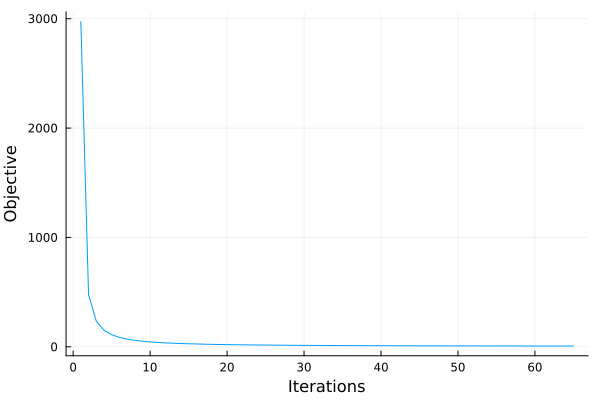

In [2]:
using Zygote, Plots

c = 10 .* randn(8)
objective(x) = sum((@. 3x^2 + 2x + c))
# objective(x) = sum( (3 .* x .^ 2) .+ (2 .* x) .+ c )

function gradient_descent(f, iterations::Integer, step_size, x0)
    iterate = copy(x0)
    history = zeros(iterations + one(iterations))
    
    for i in 1:iterations
        history[i] = f(iterate)
        
        gradient = f'(iterate)
        iterate .-= (step_size / i) .* gradient
    end
    
    history[end] = f(iterate)
    iterate, history
end

_, history = gradient_descent(objective, 64, 0.1, 20 .* rand(8))
plot(history, ylabel="Objective", xlabel="Iterations", legend=nothing)

## Workflow Demonstration

## Additional Neat Things

### Functional-style programming

- Julia has first-class functions

In [17]:
myfunc = sin
myfunc(1.0)

0.8414709848078965

This allows "higher-order" functions:

- `sort(collection; lt=... by=...)`
  - Allows specifying the comparison `<`
  - Also allows a map using `by`
  - `sort(::Vector{ComplexF32}, by=abs)`
  - `sort(::Vector{String}, by=(s -> s[1]))`

In [3]:
apply(f, x...) = f(x...)
apply(sin, π/2)

1.0

- `map(f, collection)` calls `f` on every element of `collection`
  - `foreach(f, collection)` does the same, but discards the result

- `reduce(op, collection)` applies `op` to the whole collection
  - For example, `reduce(+, collection)` is the sum
  - `reduce(*, collection)` is the product
  - `reduce(min, collection)` finds the smallest element
  - `foldl` and `foldr` guarantee direction

- `filter(pred, collection)` keeps only the elements of `collection` which satisfy `pred`
  - `filter((x -> x > zero(x)), collection)` keeps positive values
  - `filter(!isone, collection)` keeps all elements which are not the multiplicative identity

- Why should you care?
  - Some problems can be expressed much more naturally

In [1]:
import Base: map, reduce, filter

struct Tree{T}
    val::T
    children::Vector{Tree{T}}
end

Tree(val::T) where {T} = Tree(val, Tree{T}[])

val(t::Tree)      = t.val
children(t::Tree) = t.children

isleaf(t::Tree) = isempty(children(t))

isleaf (generic function with 1 method)

In [2]:
_map(f) = (st -> map(f, st))
# apply f to every node in the tree
map(f, t::Tree) =
    if isleaf(t)
        Tree(f(val(t)))
    else
        mapped_children = map(_map(f), children(t))
        Tree(f(val(t)), mapped_children)
    end

map (generic function with 48 methods)

In [3]:
_reduce(f, init) = (st -> reduce(f, st, init))
# accumulate f from the bottom of the tree to the top
reduce(f, t::Tree, init) =
    if isleaf(t)
        f(val(t), init)
    else
        inner = map(_reduce(f, init), children(t))
        f(val(t), reduce(f, inner, init=init))
    end

reduce (generic function with 7 methods)

In [4]:
# keep only subtrees whose root satisfies f, and return nothing otherwise
filter(f, t::Tree{T}) where {T} =
    if f(val(t))
        inner = Tree{T}[]
        keepnotnothing = st -> let filtered = filter(f, st)
            if !isnothing(filtered)
                push!(inner, filtered)
            end
        end
        foreach(keepnotnothing, children(t))
        Tree(val(t), inner)
    else
        nothing
    end

filter (generic function with 11 methods)

In [5]:
t = Tree(1, [
        Tree(2, [
            Tree(3),
            Tree(4),
            Tree(5)
        ]),
        Tree(6)
    ])

Tree{Int64}(1, Tree{Int64}[Tree{Int64}(2, Tree{Int64}[Tree{Int64}(3, Tree{Int64}[]), Tree{Int64}(4, Tree{Int64}[]), Tree{Int64}(5, Tree{Int64}[])]), Tree{Int64}(6, Tree{Int64}[])])

In [14]:
prettyprint(depth::Int) = (t::Tree -> prettyprint(t, depth + 1))

function prettyprint(t::Tree)
    println("┳", val(t))

    is_last = Bool[]
    for (i, child) in enumerate(children(t))
        push!(is_last, i == length(children(t)))
        prettyprint(child, 1, is_last)
        pop!(is_last)
    end
end

function prettyprint(t::Tree, depth, is_last)
    for ancestor_is_last in @view is_last[1:end-1]
        print(ancestor_is_last ? " " : "┃")
    end
    
    if is_last[end]
        println("┗", val(t))
    else
        println("┣", val(t))
    end
    
    for (i, child) in enumerate(children(t))
        push!(is_last, i == length(children(t)))
        prettyprint(child, depth + 1, is_last)
        pop!(is_last)
    end
end

prettyprint(t)

┳1
┣2
┃┣3
┃┣4
┃┗5
┗6


In [9]:
reduce(+, t, 0)

21

In [15]:
map(x -> x/2, t) |> prettyprint

┳0.5
┣1.0
┃┣1.5
┃┣2.0
┃┗2.5
┗3.0


In [24]:
filter(x -> x < 5, t) |> prettyprint

┳1
┗2
 ┣3
 ┗4


In [26]:
filter(isodd, t) |> prettyprint

┳1


### Metaprogramming

- Code is just a kind of data!

In [29]:
code_chunk = quote
    A = rand(5)
    A .+= randn(5)
    sum(A)
end

quote
    #= In[29]:2 =#
    A = rand(5)
    #= In[29]:3 =#
    A .+= randn(5)
    #= In[29]:4 =#
    sum(A)
end

In [30]:
typeof(code_chunk)

Expr

In [31]:
dump(code_chunk)

Expr
  head: Symbol block
  args: Array{Any}((6,))
    1: LineNumberNode
      line: Int64 2
      file: Symbol In[29]
    2: Expr
      head: Symbol =
      args: Array{Any}((2,))
        1: Symbol A
        2: Expr
          head: Symbol call
          args: Array{Any}((2,))
            1: Symbol rand
            2: Int64 5
    3: LineNumberNode
      line: Int64 3
      file: Symbol In[29]
    4: Expr
      head: Symbol .+=
      args: Array{Any}((2,))
        1: Symbol A
        2: Expr
          head: Symbol call
          args: Array{Any}((2,))
            1: Symbol randn
            2: Int64 5
    5: LineNumberNode
      line: Int64 4
      file: Symbol In[29]
    6: Expr
      head: Symbol call
      args: Array{Any}((2,))
        1: Symbol sum
        2: Symbol A


In [32]:
Meta.show_sexpr(code_chunk)

(:block,
  :(#= In[29]:2 =#),
  (:(=), :A, (:call, :rand, 5)),
  :(#= In[29]:3 =#),
  (:.+=, :A, (:call, :randn, 5)),
  :(#= In[29]:4 =#),
  (:call, :sum, :A)
)

In [33]:
Meta.show_sexpr(Meta.parse("1 + 1"))

(:call, :+, 1, 1)

In [34]:
macro runtwice(call)
    quote
        $call
        $call
    end
end

println("Here")
@runtwice println("Hello, world")
println("After")

Here
Hello, world
Hello, world
After


In [35]:
const DEBUG = true

macro myassert(expression::Expr)
    str = string(expression)
    if DEBUG
        quote
            if $expression
                nothing
            else
                throw(AssertionError(str))
            end
        end
    else
        quote end
    end
end

@myassert 1 == 1
macroexpand(Main, quote @myassert sqrt(2) == 1.4 end)

quote
    #= In[35]:19 =#
    begin
        #= In[35]:7 =#
        if Main.sqrt(2) == 1.4
            #= In[35]:8 =#
            Main.nothing
        else
            #= In[35]:10 =#
            Main.throw(Main.AssertionError(Main.str))
        end
    end
end